# Unseen Data Model Test

- Utilized MPI

In [86]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

In [87]:
# Reading Data
dir_name="../data/mpi_001"
cesm_dir_name="../data/data1"

## Data Preprocessing

In [88]:
sys.path.insert(0, '../src/preprocess')

from data_preprocess import preprocess_images

X, pco2_images = preprocess_images_mpi(dir_name,cesm_dir_name)

In [89]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

## MPI Dataset Result


In [90]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    #y_pred = y_pred[y_true != 0]
    #y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [91]:

best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 70ms/step


### Model 1 Result

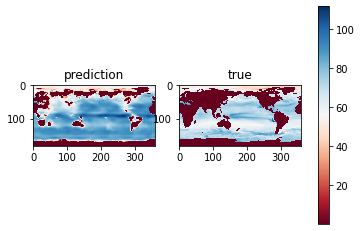

In [92]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


img=axis[0].imshow(np.flipud(np.squeeze(predicted_image[200])), cmap="RdBu", interpolation="nearest")
axis[0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[1].imshow(np.flipud(np.squeeze(pco2_images[200])), cmap="RdBu", interpolation="nearest")
axis[1].set_title("true")
plt.savefig('../assets/mpi_comparison.png', dpi=199)
plt.show()



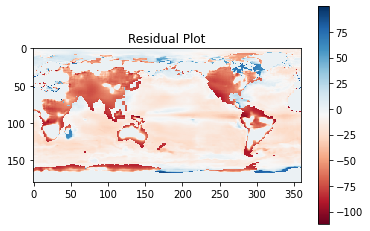

In [93]:
diff=np.flipud(np.squeeze(pco2_images[200]-predicted_image[200]))
plt.imshow(diff,cmap="RdBu", interpolation="nearest")
plt.colorbar()
plt.title("Residual Plot")

plt.savefig('../assets/mpi_residual.png', dpi=199)
plt.show()

In [94]:
# Over time

rmses = []

for i in range(421):    
    rmse = np.sqrt(np.mean((pco2_images[i]-predicted_image[i])**2))
    rmses.append(rmse)

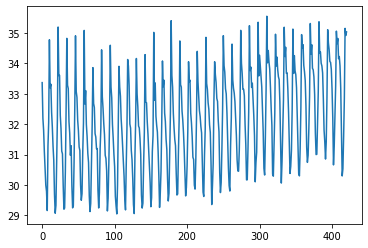

In [74]:
plt.plot(rmses)
plt.savefig('../assets/mpi_overtime.png')



In [75]:
print("RMSE score!")
np.sqrt(np.mean((predicted_image-pco2_images)**2))


RMSE score!


32.13185

## Canada Dataset

In [95]:
dir_name="../data/can_001"

In [96]:
X, pco2_images = preprocess_images_can(dir_name,cesm_dir_name)

In [97]:
best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 70ms/step


### Canada Model Result

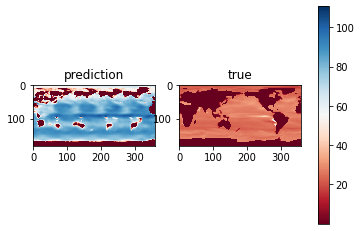

In [98]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


img=axis[0].imshow(np.flipud(np.squeeze(predicted_image[200])), cmap="RdBu", interpolation="nearest")
axis[0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[1].imshow(np.flipud(np.squeeze(pco2_images[200])), cmap="RdBu", interpolation="nearest")
axis[1].set_title("true")
plt.savefig('../assets/can_comparison.png', dpi=199)
plt.show()



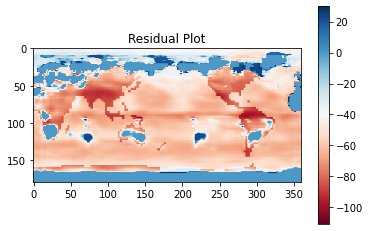

In [99]:
diff=np.flipud(np.squeeze(pco2_images[200]-predicted_image[200]))
plt.imshow(diff,cmap="RdBu", interpolation="nearest")
plt.colorbar()
plt.title("Residual Plot")

plt.savefig('../assets/can_residual.png', dpi=199)
plt.show()

In [100]:
print("RMSE score!")
np.sqrt(np.mean((predicted_image-pco2_images)**2))
# generalization works pretty well

RMSE score!


55.42691

In [ ]:
rmses = []

for i in range(421):    
    rmse = np.sqrt(np.mean((pco2_images[i]-predicted_image[i])**2))
    rmses.append(rmse)

In [ ]:
plt.plot(rmses)
plt.savefig('../assets/can_overtime.png')



In [79]:
import os
import xarray as xr
import pandas as pd
import sys
import numpy as np
sys.path.insert(0, '../src')

def read_xarray_mpi(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_MPI006_1x1_198201-201701.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_MPI006_1x1_198201-201701.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_MPI006_1x1_198201-201701.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_MPI006_1x1_198201-201701.nc')

    u10 = xr.open_dataset(f'{dir_name}/U10_2D_mon_MPI006_1x1_198201-201701.nc')

    icefrac = xr.open_dataset(f'{dir_name}/iceFrac_2D_mon_MPI006_1x1_198201-201701.nc')

    patm = xr.open_dataset(f'{dir_name}/pATM_2D_mon_MPI006_1x1_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_MPI006_1x1_198201-201701.nc')

    return chl,mld,sss,sst,u10,icefrac,patm,pco2


### Image Data Preprocess for CNN ###
def preprocess_images_mpi(dir_name,cesm_dir):
    chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(cesm_dir)
    chl,mld,sss,sst,u10,icefrac,patm,pco2 = read_xarray_mpi(dir_name)
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    
    pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    
    X = np.stack((chl_images, mld_images, sss_images, sst_images, xco2_images), axis = 1)
    X = X.reshape((421,180,360,5))

    return X, pco2_images


#
def read_xarray_can(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    u10 = xr.open_dataset(f'{dir_name}/U10_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    icefrac = xr.open_dataset(f'{dir_name}/iceFrac_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    patm = xr.open_dataset(f'{dir_name}/pATM_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_CanESM2r1r10_1x1_198201-201712.nc')

    return chl,mld,sss,sst,u10,icefrac,patm,pco2


### Image Data Preprocess for CNN ###
def preprocess_images_can(dir_name,cesm_dir):
    chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(cesm_dir)
    chl,mld,sss,sst,u10,icefrac,patm,pco2 = read_xarray_can(dir_name)
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    
    pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    
    X = np.stack((chl_images, mld_images, sss_images, sst_images, xco2_images), axis = 1)
    X = X.reshape((421,180,360,5))

    return X, pco2_images





def preprocess_image_reduced(data,xco2=False):
    if xco2:
        return xco2_preprocess(data)
    
    return scale_image(convert_nan(data))
  

### FOR SEQUENTIAL + VISION
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

### FOR VISION ###

def xco2_preprocess(data):
    """
    ## XCO2 Handling
    # - xco2 values are a constant value across the globe, 
    # - creating an image layer with constant value for the model
    # - xco2 layer improves prediction

    """
    output=[]
    min_xco2=np.min(data)
    max_xco2=np.max(data)
    new_min=0
    new_max=255
    
    for i in data:
        num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
        tmp = (np.repeat(num,180*360)).reshape(180,-1)
        output.append(tmp)
        
    output=np.array(output)

    return output


def convert_nan(arr):
    """
    convert_nan(arr)
    - converts nan values to the lowest value (continents)
    """
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val-1
    return arr

def add_dimension(arr):
    """
    add_dimension(arr)
    - add one dimension to axis=3
    """
    images=np.expand_dims(arr, axis=3)
    return images

def scale_image(arr):
    """
    scale_image(arr)
    - scales numerical values from scale 0-255 for like an image
    - have tried, regular normal/ min-max scaler -> does not work well
    """
    ## Normal
    #arr=(arr-np.mean(arr))/np.std(arr)
    
    ## Min-Max
    # min_val=arr.min()
    # max_val=arr.max()
    # arr=arr/(min_val-max_val)

    ## Image Scale
    min_pixel = arr.min() 
    max_pixel = arr.max()
    new_min = 0
    new_max = 255
    arr = (arr-min_pixel)*(255)/(max_pixel-min_pixel)+new_min 
    return arr
  


